##***Machine Learning Models***

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine 
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from prettytable import PrettyTable
from xgboost import XGBClassifier

###***Reading data from CSV file into DataFrame***

In [ ]:
#loading the data set using drive function of google colab
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd gdrive/My\ Drive/Colab Notebooks

In [ ]:
#uploading the data set and publishing the number of rows
df = pd.read_csv("final_features.csv")
print("Shape of DataFrame uploaded : ",df.shape)

Shape of DataFrame uploaded :  (404290, 232)


In [ ]:
#gettting all the columns names
column_names = list(df.columns)
print('Number of Column we have : ',len(column_names))

Number of Column we have :  232


In [ ]:
#taking a smaller subset of the entire data set
data = df[0:200000]
print('Shape of DataFrame :',data.shape)

Shape of DataFrame : (200000, 232)


In [ ]:
#Removing the irrelevant rows and seprating Y from the DataFrame  and publishing first few rows
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)
data.head(3)

,freq_qid1_x,freq_qid2_x,q1len_x,q2len_x,q1_n_words_x,q2_n_words_x,word_Common_x,word_Total_x,word_share_x,freq_q1+q2_x,freq_q1-q2_x,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1_y,freq_qid2_y,q1len_y,q2len_y,q1_n_words_y,q2_n_words_y,word_Common_y,word_Total_y,word_share_y,freq_q1+q2_y,freq_q1-q2_y,0_x,1_x,2_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,-6.179507,37.450731,-67.929894,...,120.843786,26.592192,-50.285062,114.594113,100.273874,-72.797047,85.467161,42.393031,-18.239859,-103.664753,68.317974,-46.449020,-60.184247,47.269530,-113.987847,10.320980,0.135103,-29.869163,-78.649177,77.262293,131.287160,-123.969027,20.822789,20.718112,38.093118,-85.086696,-61.891319,3.915410,-58.229361,-49.735812,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,9.236668,-80.371416,-45.785907,...,190.348300,114.510458,-79.321841,-65.284250,-69.147191,-111.427223,18.650104,15.329342,43.115542,31.039919,49.603525,-26.932295,-54.213027,98.597791,-72.848590,87.272756,2.563240,-12.326506,-50.862417,19.058227,180.085690,-79.230389,-49.612403,-2.875509,12.640813,-205.569995,-46.432224,86.927369,2.640828,-2.350201,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,97.546829,22.972195,-39.558378,...,13.483461,-63.411094,40.414527,37.971310,110.463600,-76.722634,-13.193802,38.792827,-49.570232,-142.726638,12.245693,-54.343166,-60.057482,102.482628,3.656340,-21.436032,37.960952,-25.729971,23.332562,9.404027,153.432356,-76.191487,-20.813622,-27.269100,11.735237,-20.692981,-47.580536,42.119569,49.291951,-59.756461,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858


###***Randomly splitting Data into train and test in 70:30***

In [ ]:
#using SKlearn function
X_train,X_test,y_train,y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [ ]:
#Publishing the dimension of the both the data sets
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data  :",X_test.shape)

Number of data points in train data : (140000, 229)
Number of data points in test data  : (60000, 229)


###***Understanding the distribution of output in Train and Test***

In [ ]:
#calculating the percent of each class in both the sets
train_distr  = Counter(y_train)
train_len    = len(y_train)
print("Percent of Class 0 in Train Data : ",int(train_distr[0])/train_len*100,'%')
print("Percent of Class 1 in Train Data : ",int(train_distr[1])/train_len*100,'%')
test_distr   = Counter(y_test)
test_len     = len(y_test)
print("Percent of Class 0 in Test Data  : ",int(test_distr[0])/test_len*100,'%')
print("Percent of Class 1 in Test Data  : ",int(test_distr[1])/test_len*100,'%')

Percent of Class 0 in Train Data :  62.762142857142855 %
Percent of Class 1 in Train Data :  37.237857142857145 %
Percent of Class 0 in Test Data  :  62.763333333333335 %
Percent of Class 1 in Test Data  :  37.236666666666665 %


###***Function to plots the confusion matrices***

In [ ]:
#This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)    
    A =(((C.T)/(C.sum(axis=1))).T)       
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [1,2]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()

###***Building a random model to Find the worst-case of log-loss***

Log loss on Test Data using Random Model :  0.8823590070039373



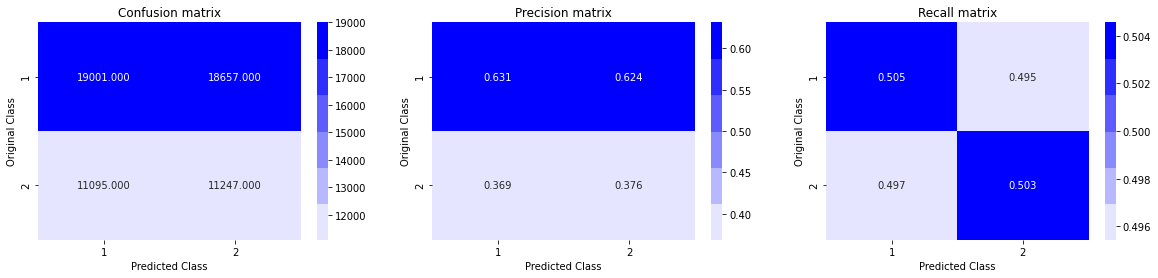

In [ ]:
#creating a function generating random outputs
predicted_y        = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs     = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model : ",log_loss(y_test, predicted_y, eps=1e-15))
print()
predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

###***Logistic Regression with hyperparameter tuning***

In [ ]:
#hyper parameter tuning and implementing logistic regression
alpha            = [10**x for x in range(-5, 2)]
log_error_array  = []
x                = PrettyTable()
x.field_names    = ["Value of Alpha", "Logg Loss"]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(round(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15),4))
    x.add_row([i,round(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15),4)])
print(x)

+----------------+-----------+
| Value of Alpha | Logg Loss |
+----------------+-----------+
|     1e-05      |   0.4427  |
|     0.0001     |   0.4521  |
|     0.001      |   0.4563  |
|      0.01      |   0.4315  |
|      0.1       |   0.4495  |
|       1        |   0.4646  |
|       10       |   0.5131  |
+----------------+-----------+


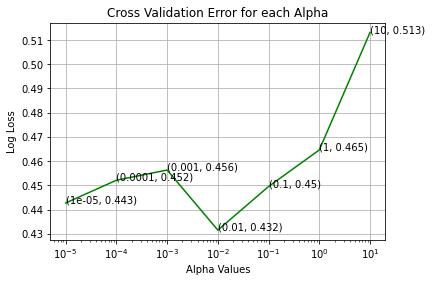

In [ ]:
#plotting value of log loss on each value of alpha
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each Alpha")
ax.set_xscale('log')
plt.xlabel("Alpha Values")
plt.ylabel("Log Loss")
plt.show() 

For values of best alpha     : 0.01
The train log loss is        : 0.4338
For values of best alpha     : 0.01
The test log loss is         : 0.4315
Total number of data points  : 60000


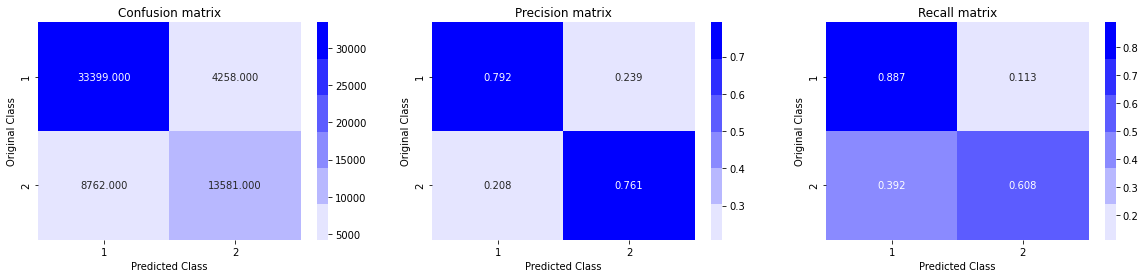

In [ ]:
#plotting confusion matrices on data set
best_alpha = np.argmin(log_error_array)
clf        = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha     :', alpha[best_alpha])
print('The train log loss is        :',round(log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15),4))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha     :', alpha[best_alpha])
print('The test log loss is         :',round(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15),4))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points  :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

###***Linear SVM with hyperparameter tuning***

In [ ]:
#hyper parameter tuning and implementing linear SVM
alpha            = [10**x for x in range(-4, 1)]
log_error_array  = []
x                = PrettyTable()
x.field_names    = ["Value of Alpha", "Logg Loss"]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(round(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15),4))
    x.add_row([i,round(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15),4)])
print(x)

+----------------+-----------+
| Value of Alpha | Logg Loss |
+----------------+-----------+
|     0.0001     |   0.6602  |
|     0.001      |   0.6602  |
|      0.01      |   0.4879  |
|      0.1       |   0.582   |
|       1        |   0.6602  |
+----------------+-----------+


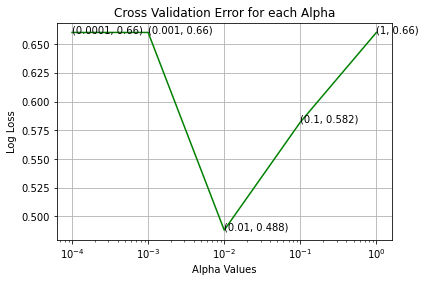

In [ ]:
#plotting value of log loss on each value of alpha
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each Alpha")
ax.set_xscale('log')
plt.xlabel("Alpha Values")
plt.ylabel("Log Loss")
plt.show()

For values of best alpha     : 0.01
The train log loss is        : 0.4362
For values of best alpha     : 0.01
The test log loss is         : 0.4381
Total number of data points  : 60000


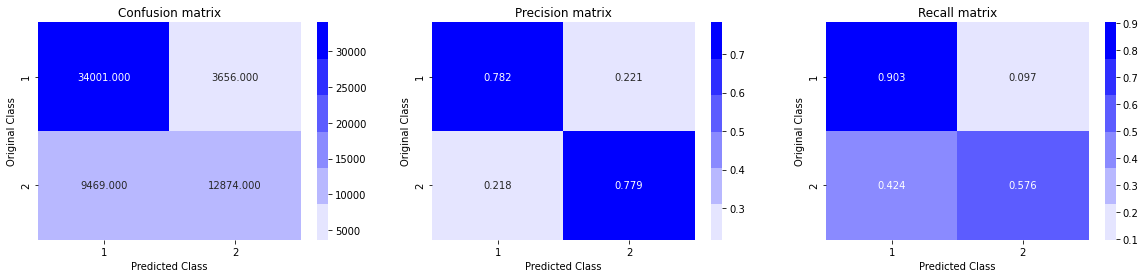

In [ ]:
#plotting confusion matrices on data set
best_alpha = np.argmin(log_error_array)
clf        = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha     :', alpha[best_alpha])
print('The train log loss is        :',round(log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15),4))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha     :', alpha[best_alpha])
print('The test log loss is         :',round(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15),4))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points  :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

###***XGBoost with hyperparameter tuning***

In [ ]:
#implementing the xgboost
max_depth_val   = [3,4,5]
x               = PrettyTable()
x.field_names   = ['Max Depth', 'Log Loss']
log_error_array = []
for i in max_depth_val:
    clf = XGBClassifier(max_depth=i, eta=0.01,objective='binary:logistic',eval_metric='logloss')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(round(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15),4))
    x.add_row([i,round(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15),4)])
print(x)

+-----------+----------+
| Max Depth | Log Loss |
+-----------+----------+
|     3     |  0.3726  |
|     4     |  0.3626  |
|     5     |  0.3554  |
+-----------+----------+


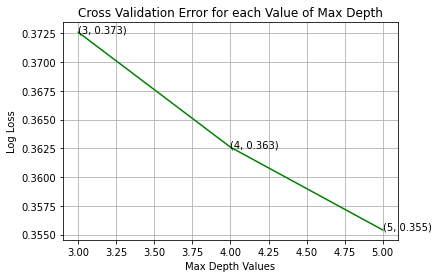

In [ ]:
#plotting value of log loss on each value of alpha
fig, ax = plt.subplots()
plt.plot(max_depth_val, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((max_depth_val[i],np.round(txt,3)), (max_depth_val[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each Value of Max Depth")
plt.xlabel("Max Depth Values")
plt.ylabel("Log Loss")
plt.show()

For values of best alpha     : 5
The train log loss is        : 0.3345
For values of best alpha     : 5
The test log loss is         : 0.3554
Total number of data points  : 60000


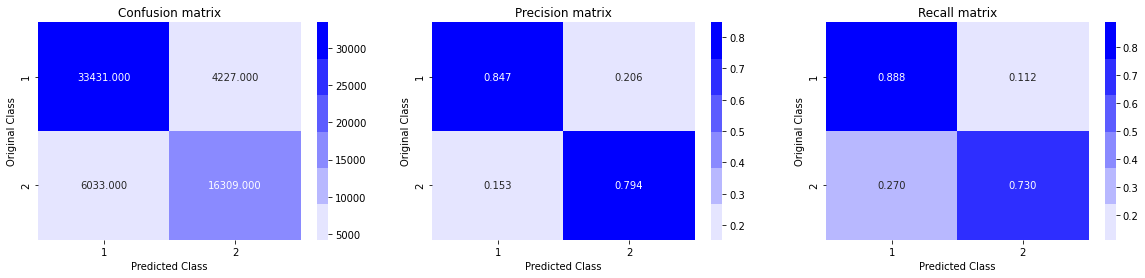

In [ ]:
#plotting confusion matrices on data set
best_alpha = np.argmin(log_error_array)
clf = XGBClassifier(max_depth=max_depth_val[best_alpha], eta=0.01,objective='binary:logistic',eval_metric='logloss')
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha     :', max_depth_val[best_alpha])
print('The train log loss is        :',round(log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15),4))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha     :', max_depth_val[best_alpha])
print('The test log loss is         :',round(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15),4))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points  :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

***Conclusion :***
>*Implementing Logistic Regression on Feature Engineered Data Set, after appropriatly tuning the Hyper-Parameters, we are able to get log loss on Test Data as* ***0.4315***

>*Implementing Linear SVM on Feature Engineered Data Set, after appropriatly tuning the Hyper-Parameters, we are able to get log loss on Test Data as* ***0.4381***

>*Implementing XGboost for classification on Feature Engineered Data Set, after appropriatly tuning the Hyper-Parameters, we are able to get log loss on Test Data as* ***0.3554***


###***--End of Notebook--***